## Purwadhika Data Science Final Project - Natural Language Processing ##

[Spam Message Dataset](https://www.kaggle.com/team-ai/spam-text-message-classification) is used for this project. This dataset will be used for train machine learning model to predict and classify the emotion from the text data of tweet.  
  
It consists of combining machine learning techniques with text using math and statistics to get that text in a format that the machine learning algorithms can understand.

In [1]:
import numpy as np
import warnings

### Check out the Data


In [2]:
import pandas as pd

In [3]:
df= pd.read_csv('data/SPAM text message 20170820 - Data.csv')
df.head(5)
len(df)

5572

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Category    5572 non-null object
Message     5572 non-null object
dtypes: object(2)
memory usage: 43.6+ KB


### Exploratory Data Analysis



Let's use groupby to use describe by Category, this way we can begin to think about the features that separate ham and spam!


In [5]:
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [6]:
df.groupby('Category').describe()


Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

Let's make a new column to detect how long the text messages are

In [7]:
df['Length'] = df['Message'].apply(len)
df.head()

,Category,Message,Length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Text Cleaning

clean the text for the messages in dataset

============================

    Takes in a string of text, then performs the following:
    1. Handling lower/upper case
    2. Tokenizer
    3. Removing stopwords
    3. Lemmatizing text
    4. Returns a list of the cleaned text


In [10]:
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet

In [11]:
df["Category"] = df["Category"].map({'ham': 0,'spam':1})

In [12]:
wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')
stop_words = set(stopwords.words('english'))
def preprocess(document):
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)

In [13]:
df['Processed'] = df['Message'].apply(preprocess)

df.head()

,Category,Message,Length,Processed
0,0,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...
3,0,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah think go usf life around though


### Vectorization

Now we have the messages as lists and we need to convert each of those messages into a vector that SciKit Learn's algorithm models can work with.


In [14]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer


In [15]:
bow_trans= CountVectorizer().fit(df['Processed'])

In [21]:
message_bow = bow_trans.transform(df['Processed'])

### TF- IDF ###
__Term Frequency-Inverse Document Frequency__

In [22]:
tfidf_transformer = TfidfTransformer().fit(message_bow)
tfidf4 = tfidf_transformer.transform(message_bow)
# print(tfidf4)

### Train Test Split ###

In [23]:
from sklearn.model_selection import train_test_split


In [24]:
y = df.iloc[:,0].values
x= df['Message']
xtr, xts, ytr, yts = train_test_split(x ,y,test_size = 0.25,random_state=42)
print(len(xts))

1393


## Training a Model ##
I using **scikit-learn's** [pipeline](http://scikit-learn.org/stable/modules/pipeline.html) to store a pipeline of workflow. This will allow me to set up all the transformations that we will do to the data for future use.

The process of pipeline include:
- Using **CountVectorizer** to convert those message into a matrix of token counts.
- Using **TfidfTransformer** to measures how frequent a term occurs in a document and measures how important a term is.
- Last step of the pipeline is decide the machine learning for the classifier.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

### Model with Params ###

In [27]:
pipeline = Pipeline([
    ('cv',CountVectorizer(analyzer=preprocess)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])    
# )

In [28]:
pipeline.fit(xtr,ytr)

Pipeline(memory=None,
         steps=[('cv',
                 CountVectorizer(analyzer=<function preprocess at 0x133F9E80>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [30]:
n_estimators = np.arange(100,400,100)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,20,30, None]

pipeline_RandomForest = Pipeline([
    ('bow', CountVectorizer(analyzer=preprocess)),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', RandomForestClassifier(max_depth= 10, max_features= 'sqrt', n_estimators= 100)),  # train on TF-IDF vectors with Random Forest
])


In [ ]:
pipeline_RandomForest.fit(xtr,ytr)

In [ ]:
pipeline_SVC = Pipeline([
    ('CV', CountVectorizer(analyzer=preprocess)),  # strings to token integer counts
    ('tfidf',TfidfTransformer()),
    ('classifier', SVC(C= 100, gamma= 0.01, kernel= 'rbf',probability=True))  # train on TF-IDF vectors with Random Forest
])

In [36]:


pipeline_SVC.fit(xtr,ytr)


Pipeline(memory=None,
         steps=[('CV',
                 CountVectorizer(analyzer=<function preprocess at 0x14E4EE38>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 token...bulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 SVC(C=100, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_

In [37]:
multinomial_prediksi = pipeline.predict(xts)
Forest_prediksi = pipeline_RandomForest.predict(xts)
SVC_prediksi = pipeline_SVC.predict(xts)

#### MultinomialNB ####

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1207
           1       0.00      0.00      0.00       186

    accuracy                           0.87      1393
   macro avg       0.43      0.50      0.46      1393
weighted avg       0.75      0.87      0.80      1393



c:\users\dell\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 15.0, 'Predicted label')

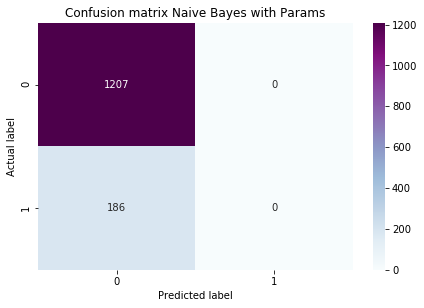

In [38]:
print(classification_report(yts,multinomial_prediksi))

cm = confusion_matrix(yts,multinomial_prediksi)
sb.heatmap(pd.DataFrame(cm),annot=True, cmap="BuPu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix Naive Bayes with Params', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Random Forest ####

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1207
           1       0.93      0.73      0.82       186

    accuracy                           0.96      1393
   macro avg       0.95      0.86      0.90      1393
weighted avg       0.96      0.96      0.95      1393



Text(0.5, 15.0, 'Predicted label')

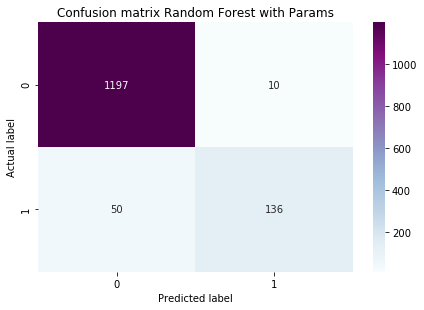

In [39]:
print(classification_report(yts,Forest_prediksi))

cm2 = confusion_matrix(yts,Forest_prediksi)
sb.heatmap(pd.DataFrame(cm2),annot=True, cmap="BuPu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix Random Forest with Params', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Support Vector Machine ####

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1207
           1       0.84      0.60      0.70       186

    accuracy                           0.93      1393
   macro avg       0.89      0.79      0.83      1393
weighted avg       0.93      0.93      0.93      1393



Text(0.5, 15.0, 'Predicted label')

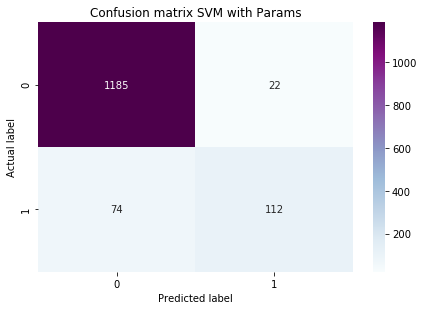

In [40]:
print(classification_report(yts,SVC_prediksi))

cm2 = confusion_matrix(yts,SVC_prediksi)
sb.heatmap(pd.DataFrame(cm2),annot=True, cmap="BuPu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix SVM with Params', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

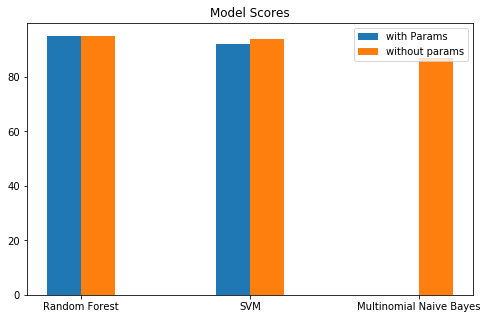

In [41]:
N = 3
hyperparameter = (95, 92, 0)

fig, ax = plt.subplots(figsize=(8,5))

ind = np.arange(N)    # the x locations for the groups
width = 0.2         # the width of the bars
p1 = ax.bar(ind, hyperparameter, width, bottom=0)

score = (95, 94, 87)
p2 = ax.bar(ind + width, score, width, bottom=0)

ax.set_title('Model Scores')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Random Forest', 'SVM', 'Multinomial Naive Bayes'))
ax.legend((p1[0], p2[0]), ('with Params','without params',))
ax.autoscale_view()
plt.show()


It seems **Random Forest with Params** achieve highest accuracy compared to the other models.

Now trying to test the model using the **data** that model never seen before.

In [42]:
Message = ['Pizza Delivery']
prediksi_test_cnb = pipeline_RandomForest.predict(Message)

In [43]:
Message2=['Urgent please call 098644289085 from your phone. Your complimentary 7* voucher Holiday or 30,000 cash await collection H & M PO BOX 6378 SG728 9KL 150 ppm 18+']

In [ ]:
prediksi_test_cnb 

In [ ]:
pipeline_RandomForest.predict_proba(Message)

### Create Joblib Model for Applications ###

In [ ]:
import joblib

In [ ]:
# joblib.dump(pipeline_RandomForest, 'model_Message_Tantun')